In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
"""
CSSP via continious optimization as done in the paper (Moka et al., 2023).

The definitions of the terms are as follows:

X : The original data matrix (m,n) over which we apply CSSP to drop the columns. 
Here X is the small dataset comprising of 3 main columns, 2 correlated columns, 10 error columns and the y vector. 


delta : Fixed constant (parameter to control the penalized term in projection matrix)


t : The column (n,1), each element between 0 and 1 (continious). Getting a value less than 
threshold value (0.5 in paper) indicates the column can be dropped. 


w : Non linear transform from t, (-log(1-t)) to make the optimization problem unconstrained.


lambda_ : Regularization parameter.


M : Monte Carlo size, used for approximation during gradient calculation, reducing computational complexity. 
In paper, M = 5. 


max_iter : Iterations done for gradient descent algorithm. 


S_j : Column vector of size n, used for getting optimal t and tolerance condition (explained later).


Gradient descent algorithm is used to solve the optimization problem.

"""

### Define Projection Matrix for continious optimization

In [2]:
def Projection_matrix(X, t, delta):
    T0 = np.diag(t)
    convex1 = T0 @ X.T @ X @ T0
    I = np.eye(T0.shape[0])
    convex2 =  delta * (I - T0 @ T0)
    p_term = convex1 + convex2
    Pt = X @ T0 @ np.linalg.inv(p_term) @ T0 @ X.T
    return Pt

### Objective function or the Lagrangian

In [3]:
def objective(X, t, delta, lambda_):
    Pt = Projection_matrix(X, t, delta)
    trace_term = -np.trace(X.T @ Pt @ X)
    regularization_term = lambda_ * np.sum(t)
    return trace_term + regularization_term

### Computing the matrices required for gradient

In [4]:
def compute_matrices(X, t, delta):
    T0 = np.diag(t)
    K = X.T @ X
    Z = K - delta * np.eye(K.shape[0])
    Lt = T0 @ Z @ T0 + delta * np.eye(T0.shape[0])
    return K, Z, Lt, T0

def compute_phi(X, t, delta, lambda_, M):
    K, Z, Lt, T0 = compute_matrices(X, t, delta)
    phi_samples = []
    for _ in range(M):
        # Rademacher distribution
        z = np.random.choice([-1, 1], size=(K.shape[0],))  
        a = K @ z
        b = np.linalg.inv(Lt) * (t * a)  # Element-wise multiplication
        phi = (b * (Z @ (t * b))) - (a * b)  
        phi_samples.append(phi)
    phi_mean = np.mean(phi_samples, axis=0)
    return phi_mean

### Computing gradient using Monte Carlo size M approximation

In [5]:
def gradient(X, t, delta, lambda_, M):
    phi_mean = compute_phi(X, t, delta, lambda_, M)
    gradient = 2 * (1 / M) * phi_mean + lambda_ * np.eye(X.shape[1])
    return np.diag(gradient)

### Non linear transformation from t to w

In [6]:
def t_to_w(t):
    return np.sqrt(-np.log(1 - t))

def w_to_t(w):
    return 1 - np.exp(-(w*w))

### Gradient Descent Algorithm

In [7]:
def gradient_descent(X, w_init, delta, lambda_, learning_rate, max_iter, M):
    w = w_init
    
    for i in range(max_iter):
        grad = gradient(X, w, delta, lambda_, M)
        w -= learning_rate * grad
        t = w_to_t(w)
        
        for j in range(len(t)):
            if t[j] <= 0.5:    # threshold value taken as 0.5
                S_j[j] += 1
    
        if i % 100 == 0:
            print(f"Iteration {i}: t = {t}")
            print("\n")
            print(f"Iteration{i}: Objective Value={objective(X, w, delta, lambda_)}")
            print("\n")
        
    return w

### Compute t for small dataset over different iterations

In [9]:
np.random.seed(0)
# Import data (small dataset)
df = pd.read_csv("D2XL1_small dataset.csv")
X = df.values 

n = X.shape[1]  
m = X.shape[0]  

# Initialize t and w
t_init = np.full(n, 0.5)  
w_init = np.sqrt(-np.log(1 - t_init))

# Initialize S_j 
S_j = np.full(n, 0)

# Constants
delta = 1
lambda_ = 1
learning_rate = 0.00001
max_iter = 2000
M = 5 # Monte Carlo sample size

# Optimized w and t using gradient descent
optimized_w = gradient_descent(X, w_init, delta, lambda_, learning_rate, max_iter, M)
print("\n")

Iteration 0: t = [0.50250896 0.57186874 0.50147198 0.50001565 0.4999988  0.53893489
 0.56105114 0.57281518 0.52993947 0.57033448 0.57815865 0.52373797
 0.53287367 0.50827644 0.51347086 0.50017448]


Iteration0: Objective Value=-379159.6157963624


Iteration 100: t = [1.         1.         1.         0.99999992 0.49377481 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]


Iteration100: Objective Value=-379113.5555219474


Iteration 200: t = [1.         1.         0.99999999 0.99989732 0.48741005 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]


Iteration200: Objective Value=-379591.6809315111


Iteration 300: t = [0.78335331 1.         0.5543835  0.9558786  0.48116245 1.
 1.         1.         1.         1.         1.         1.
 1.         0.8783644  0.97759938 1.        ]


Iteration300: Objective Value=-379528.30315875536


Iteration 400: t = [1.         1.         0

### Getting optimal t and tolerance condition

In [ ]:
"""
From the previous block we can see how the objective function is changing
with gradient descent. Note that, the objective value differs by a small margin
with each iteration, often bouncing back and forth. However even with almost same 
objective function value, we can see noticeable differences in t. For this reason,
a rigid tolerance condition might give a very biased result.

For this reason, a zero vector S_j (n,1) is initialized. With each iteration, if 
some element of t is less than 0.5 (threshold) then the corresponding element of S_j gets an 
increment by 1. Thus over all the iteration, the elements of S_j records the number
of times the corresponding element of t had value less than 0.5 (threshold). 

This gives a better picture on which columns of X has been dropped the most over all
the iterations of the algorithm. Also note that the objective function value over 
almost all these iterations are very close with no such significant differences (this 
can be achieved with proper choice of learning rate and number of iterations, getting 
very close to the region around global or local minimum).

The paper (Moka et al., 2023) doesn't give much information on the tolerance conditions
or the sensitivity of data with all parameters. 

"""

In [ ]:
"""
From the results optimal t is achieved at iteration 700, where columns 4 and 5 are below
threshold. 
"""

### Results

In [10]:
print(S_j)

[  37    0   84  743 2000    4    4    2    7    1    1   18   10  116
   28    3]


In [ ]:
"""
From S_j, we see column 4 has been below threshold 743 times and column 5 below threshold 200 times 
out of the iterations (2000). None of the other columns have been dropped to such number of times.

Column 4 has been dropped 37% and column 5 dropped 100% over all iterations. 
Rest all columns have been dropped less than 10%.

This provides strong reasoning for dropping out the 4th and 5th column of the dataset.
"""

### Hyper parameter tuning for lambda

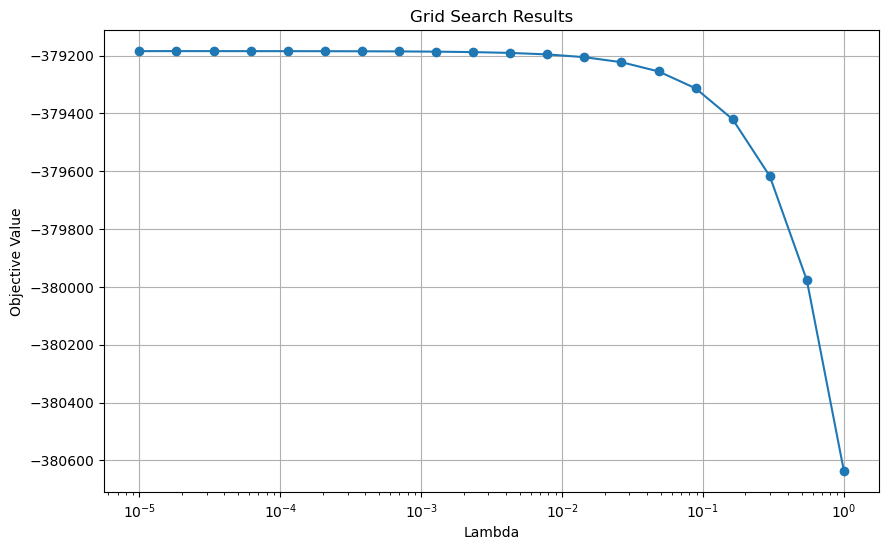

In [11]:
"""
The values of lambda and delta depends on data. The paper mentions d = 1 as optimal, 
and do a grid search for value of lambda. 

"""

def grid_search(X, w_init, delta, lambdas, learning_rate, max_iter, M):
    results = []
    for lambda_ in lambdas:
        obj_value = objective(X, optimized_w, delta, lambda_)  
        results.append((lambda_, obj_value))
    return results

lambda_values = np.logspace(-5, 0, 20)

results = grid_search(X, w_init, delta, lambda_values, learning_rate, max_iter, M)

lambdas, objective_values = zip(*results)
plt.figure(figsize=(10, 6))
plt.semilogx(lambdas, objective_values, marker='o')
plt.xlabel('Lambda')
plt.ylabel('Objective Value')
plt.title('Grid Search Results')
plt.grid(True)
plt.show()

In [ ]:
"""
Lambda = 1 seems optimal from the figure

"""

In [ ]:
"""
Note that the optimal values of lambda_ and delta are dependent on data and sensitive. 
High values of lambda_ will push the more w's to zero, delta meanwhile is taken as 1 like in the paper. 

The result is highly sensitive to M and learning rate of gradient descent, 
which also is dependent on data. Carrying parameter tuning over all can be tedious 
and computationally expensive. 

So for each dataset, we need to figure out the values of lamda_, M and learning rate 
to get the optimal results.This can be too tedious. A better way to get these 
values is needed. (to be done). 


"""